In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline


import warnings
warnings.filterwarnings('ignore')

In [ ]:
import re
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [ ]:
print("=" * 80)
print("REDDIT COMMENT SENTIMENT ANALYSIS")
print("=" * 80)


REDDIT COMMENT SENTIMENT ANALYSIS


1. DATA LOADING AND EXPLORATION

In [ ]:

df = pd.read_csv('/content/drive/MyDrive/ML-APU/reddit.csv')

In [ ]:
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,Positive
1,buddhism has very much lot compatible with chr...,Positive
2,seriously don say thing first all they won get...,Negative
3,what you have learned yours and only yours wha...,Neutral
4,for your own benefit you may want read living ...,Positive


In [ ]:
df.shape

(37249, 2)

In [ ]:
df.isnull().sum()

,0
clean_comment,100
category,0


In [ ]:
category_counts = df['category'].value_counts()

In [ ]:
category_counts

,count
category,
Positive,15830
Neutral,13142
Negative,8277


In [ ]:
df['category'].nunique()

3

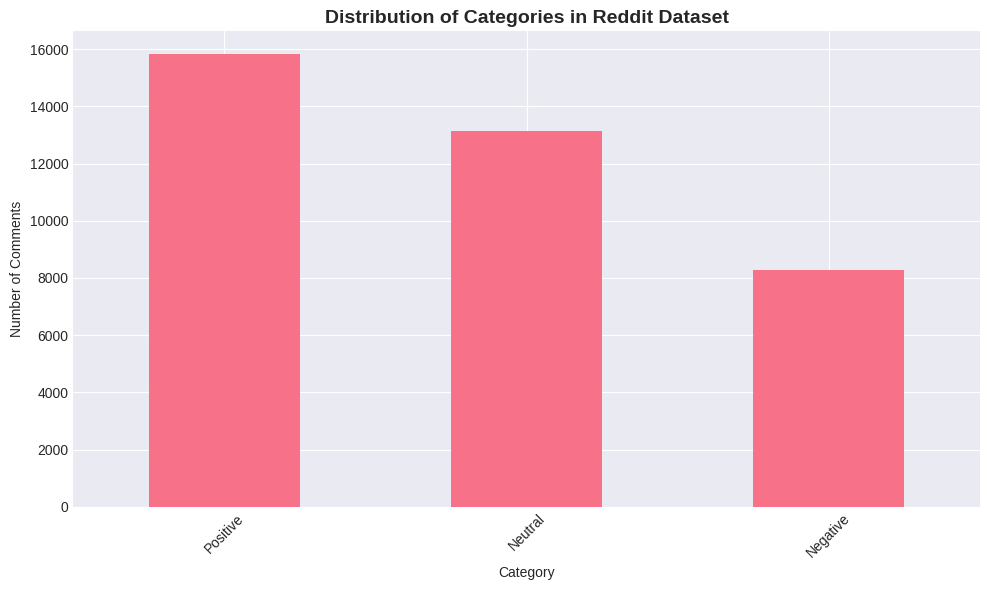

In [ ]:
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Distribution of Categories in Reddit Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Category')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
print("Text Statistics:")

df['comment_length'] = df['clean_comment'].str.len()
df['word_count'] = df['clean_comment'].str.split().str.len()
print(f"Average comment length: {df['comment_length'].mean():.2f} characters")
print(f"Average word count: {df['word_count'].mean():.2f} words")
print(f"Shortest comment: {df['comment_length'].min()} characters")
print(f"Longest comment: {df['comment_length'].max()} characters")

Text Statistics:
Average comment length: 181.39 characters
Average word count: 29.40 words
Shortest comment: 1.0 characters
Longest comment: 8665.0 characters


In [ ]:
print(df['comment_length'].min())

1.0


In [ ]:
df

,clean_comment,category,comment_length,word_count
0,family mormon have never tried explain them t...,Positive,261.0,39.0
1,buddhism has very much lot compatible with chr...,Positive,1269.0,196.0
2,seriously don say thing first all they won get...,Negative,460.0,86.0
3,what you have learned yours and only yours wha...,Neutral,168.0,29.0
4,for your own benefit you may want read living ...,Positive,691.0,112.0
...,...,...,...,...
37244,jesus,Neutral,5.0,1.0
37245,kya bhai pure saal chutiya banaya modi aur jab...,Positive,99.0,19.0
37246,downvote karna tha par upvote hogaya,Neutral,38.0,6.0
37247,haha nice,Positive,10.0,2.0


In [ ]:
print("\n" + "=" * 80)
print("2. DATA PREPROCESSING")
print("=" * 80)


2. DATA PREPROCESSING


In [ ]:
# Drop rows with missing comments
print(f"Dropping {df['clean_comment'].isnull().sum()} rows with missing comments...")
df = df.dropna(subset=['clean_comment'])


Dropping 100 rows with missing comments...


In [ ]:
def preprocess_text(text):
    """Enhanced text preprocessing function"""
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)

    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text

# Apply preprocessing
df['processed_text'] = df['clean_comment'].apply(preprocess_text)


In [ ]:
df['processed_text']

,processed_text
0,family mormon have never tried explain them th...
1,buddhism has very much lot compatible with chr...
2,seriously don say thing first all they won get...
3,what you have learned yours and only yours wha...
4,for your own benefit you may want read living ...
...,...
37244,jesus
37245,kya bhai pure saal chutiya banaya modi aur jab...
37246,downvote karna tha par upvote hogaya
37247,haha nice


In [ ]:
# Encode target variable
print("Encoding target variable...")
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['category'])

print("Label encoding mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {label}: {i}")

Encoding target variable...
Label encoding mapping:
  Negative: 0
  Neutral: 1
  Positive: 2


In [ ]:
print("\n" + "=" * 80)
print("3. FEATURE ENGINEERING")
print("=" * 80)


3. FEATURE ENGINEERING


In [ ]:
X = df['processed_text']
y = df['category_encoded']

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
print(f"Training set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")


Training set size: 29719 samples
Test set size: 7430 samples


In [ ]:
# Create TF-IDF features for traditional ML models
print("Creating TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9,
    stop_words='english'
)


Creating TF-IDF features...


In [ ]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")
print(f"Number of features: {X_train_tfidf.shape[1]}")

TF-IDF feature matrix shape: (29719, 5000)
Number of features: 5000


In [ ]:
# Prepare data for deep learning models
print("Preparing data for deep learning...")
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

max_len = 100
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding='post', truncating='post')

print(f"Padded sequence shape: {X_train_padded.shape}")

Preparing data for deep learning...
Padded sequence shape: (29719, 100)


In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, is_deep_learning=False):
    """Enhanced model evaluation function"""
    print(f"\n{'-' * 60}")
    print(f"Training {model_name}...")
    print(f"{'-' * 60}")

    if is_deep_learning:
        # For deep learning models
        history = model.fit(
            X_train, y_train,
            epochs=10,
            batch_size=32,
            validation_split=0.2,
            callbacks=[
                EarlyStopping(patience=3, restore_best_weights=True),
                ReduceLROnPlateau(patience=2, factor=0.5)
            ],
            verbose=1
        )

        # Predictions
        y_pred_prob = model.predict(X_test)
        y_pred_test = np.argmax(y_pred_prob, axis=1)

        # Training accuracy (approximate from last validation)
        train_accuracy = max(history.history['accuracy'])
        test_accuracy = accuracy_score(y_test, y_pred_test)

    else:
        # For traditional ML models
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        train_accuracy = accuracy_score(y_train, y_pred_train)
        test_accuracy = accuracy_score(y_test, y_pred_test)

    # Calculate metrics
    precision = precision_score(y_test, y_pred_test, average='weighted')
    recall = recall_score(y_test, y_pred_test, average='weighted')
    f1 = f1_score(y_test, y_pred_test, average='weighted')

    # Print results
    print(f"\nResults for {model_name}:")
    print(f"  Training Accuracy: {train_accuracy:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")

    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred_test, target_names=label_encoder.classes_))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    return {
        'model': model,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': y_pred_test
    }



MODEL 1: MULTINOMIAL NAIVE BAYES



------------------------------------------------------------
Training Naive Bayes...
------------------------------------------------------------

Results for Naive Bayes:
  Training Accuracy: 0.7154
  Test Accuracy: 0.6494
  Precision: 0.7140
  Recall: 0.6494
  F1-Score: 0.6316

Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.35      0.50      1655
     Neutral       0.78      0.53      0.63      2609
    Positive       0.57      0.91      0.70      3166

    accuracy                           0.65      7430
   macro avg       0.74      0.59      0.61      7430
weighted avg       0.71      0.65      0.63      7430



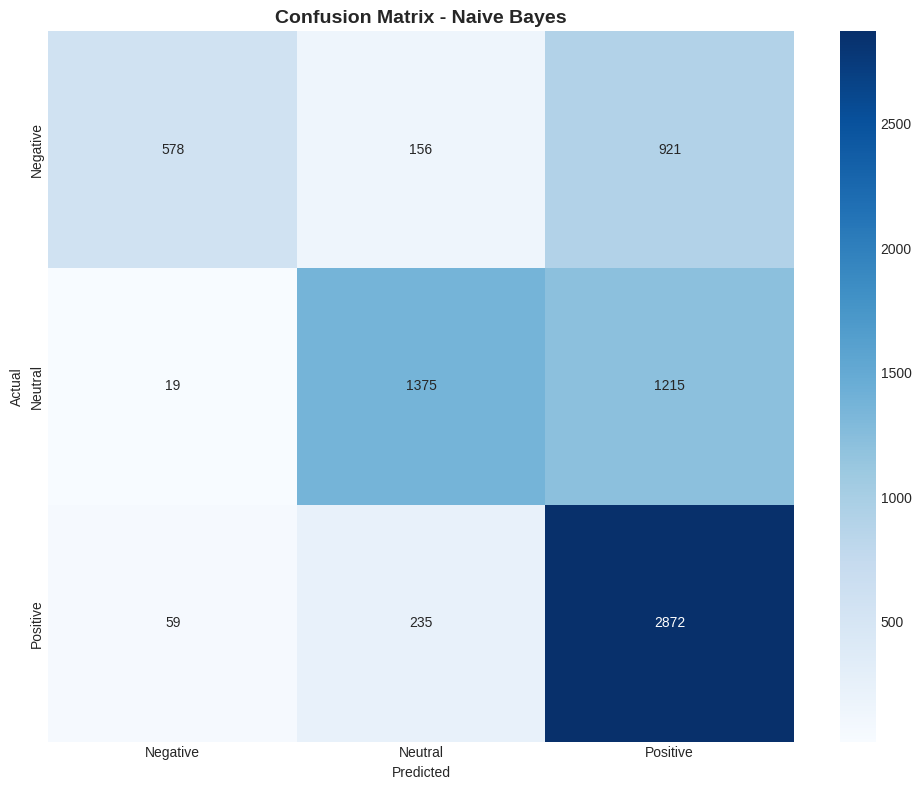

In [ ]:
nb_model = MultinomialNB(alpha=1.0)
nb_results = evaluate_model(nb_model, X_train_tfidf, y_train, X_test_tfidf, y_test, "Naive Bayes")


 MODEL 2: LOGISTIC REGRESSION



------------------------------------------------------------
Training Logistic Regression...
------------------------------------------------------------

Results for Logistic Regression:
  Training Accuracy: 0.8594
  Test Accuracy: 0.8155
  Precision: 0.8211
  Recall: 0.8155
  F1-Score: 0.8096

Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.58      0.69      1655
     Neutral       0.79      0.94      0.86      2609
    Positive       0.83      0.83      0.83      3166

    accuracy                           0.82      7430
   macro avg       0.83      0.79      0.79      7430
weighted avg       0.82      0.82      0.81      7430



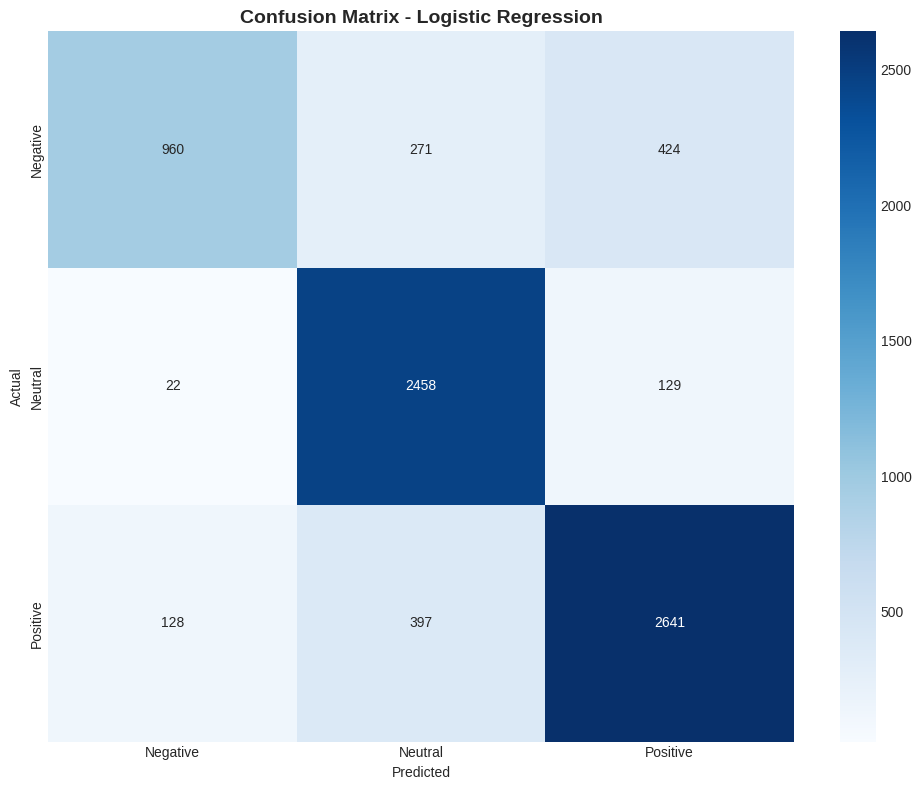

In [ ]:
lr_model = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr', solver='liblinear')
lr_results = evaluate_model(lr_model, X_train_tfidf, y_train, X_test_tfidf, y_test, "Logistic Regression")



MODEL 3: RANDOM FOREST CLASSIFIER

------------------------------------------------------------
Training Random Forest...
------------------------------------------------------------

Results for Random Forest:
  Training Accuracy: 0.6999
  Test Accuracy: 0.6746
  Precision: 0.7209
  Recall: 0.6746
  F1-Score: 0.6220

Classification Report:
              precision    recall  f1-score   support

    Negative       0.91      0.12      0.20      1655
     Neutral       0.66      0.88      0.76      2609
    Positive       0.67      0.80      0.73      3166

    accuracy                           0.67      7430
   macro avg       0.75      0.60      0.56      7430
weighted avg       0.72      0.67      0.62      7430



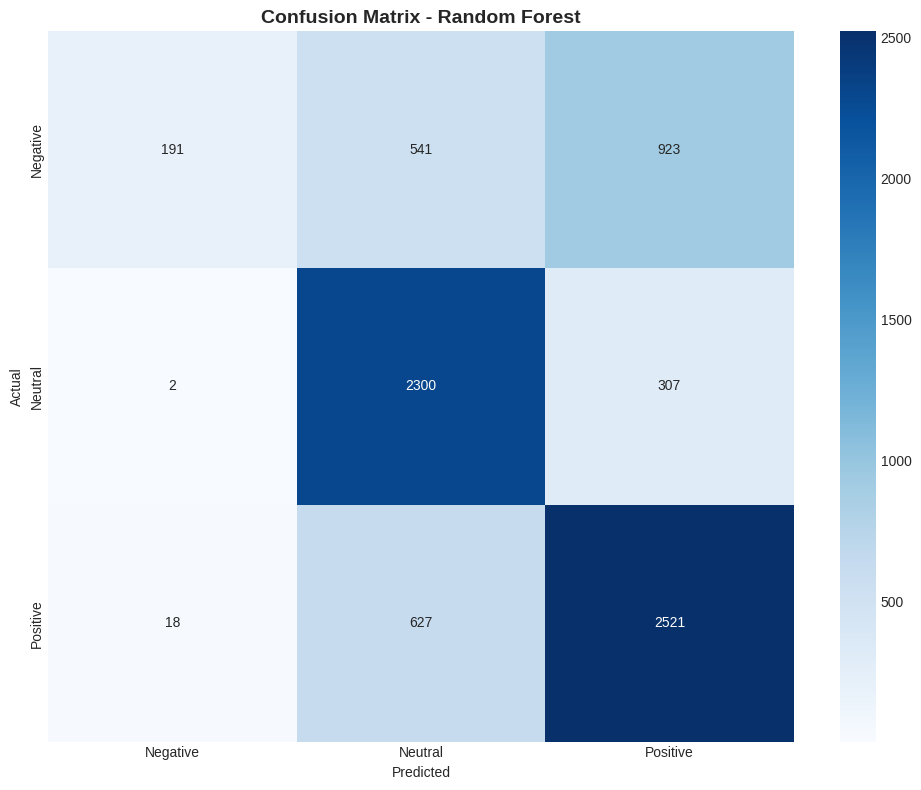

In [ ]:
print("\n" + "=" * 80)
print("MODEL 3: RANDOM FOREST CLASSIFIER")
print("=" * 80)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42,
                                  max_depth=20, min_samples_split=5)
rf_results = evaluate_model(rf_model, X_train_tfidf, y_train,
                           X_test_tfidf, y_test, "Random Forest")

 MODEL 3: RANDOM FOREST CLASSIFIER



------------------------------------------------------------
Training Random Forest...
------------------------------------------------------------

Results for Random Forest:
  Training Accuracy: 0.6999
  Test Accuracy: 0.6746
  Precision: 0.7209
  Recall: 0.6746
  F1-Score: 0.6220

Classification Report:
              precision    recall  f1-score   support

    Negative       0.91      0.12      0.20      1655
     Neutral       0.66      0.88      0.76      2609
    Positive       0.67      0.80      0.73      3166

    accuracy                           0.67      7430
   macro avg       0.75      0.60      0.56      7430
weighted avg       0.72      0.67      0.62      7430



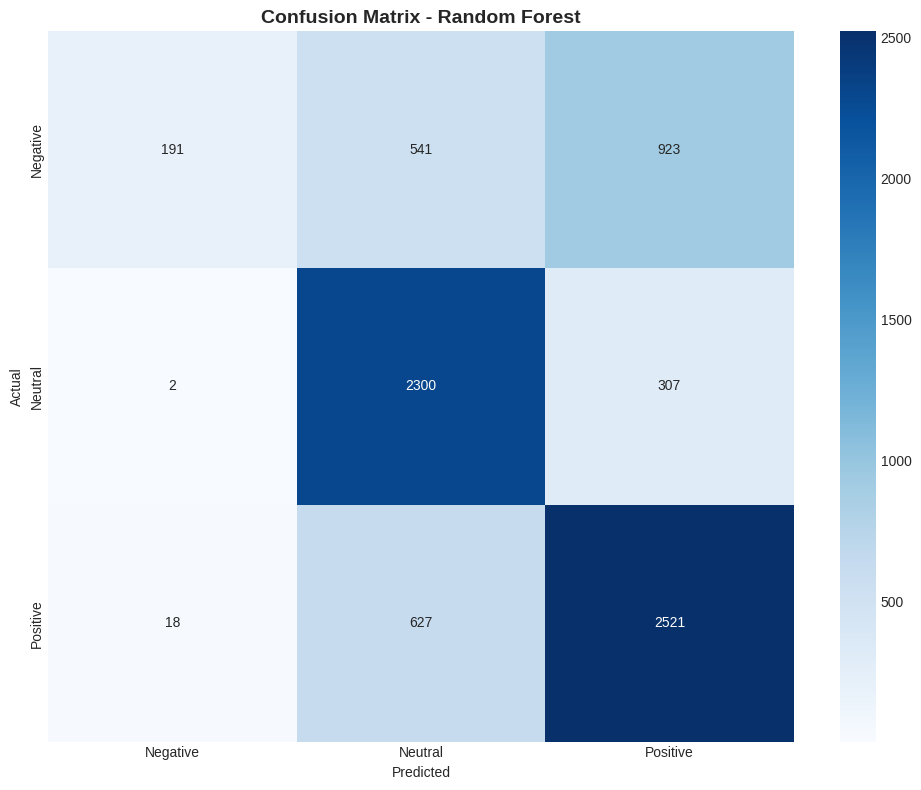

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=20, min_samples_split=5)
rf_results = evaluate_model(rf_model, X_train_tfidf, y_train, X_test_tfidf, y_test, "Random Forest")



MODEL 4: DEEP LEARNING (LSTM)

LSTM Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


------------------------------------------------------------
Training LSTM...
------------------------------------------------------------
Epoch 1/10
743/743 ━━━━━━━━━━━━━━━━━━━━ 250s 326ms/step - accuracy: 0.4158 - loss: 1.0626 - val_accuracy: 0.4224 - val_loss: 1.0330 - learning_rate: 0.0010
Epoch 2/10
743/743 ━━━━━━━━━━━━━━━━━━━━ 255s 317ms/step - accuracy: 0.6021 - loss: 0.8794 - val_accuracy: 0.8304 - val_loss: 0.4922 - learning_rate: 0.0010
Epoch 3/10
743/743 ━━━━━━━━━━━━━━━━━━━━ 236s 318ms/step - accuracy: 0.8345 - loss: 0.4781 - val_accuracy: 0.8599 - val_loss: 0.4106 - learning_rate: 0.0010
Epoch 4/10
743/743 ━━━━━━━━━━━━━━━━━━━━ 237s 319ms/step - accuracy: 0.8765 - loss: 0.3862 - val_accuracy: 0.8933 - val_loss: 0.3335 - learning_rate: 0.0010
Epoch 5/10
743/743 ━━━━━━━━━━━━━━━━━━━━ 261s 317ms/step - accuracy: 0.9163 - loss: 0.2939 - val_accuracy: 0.9039 - val_loss: 0.3096 - learning_rate: 0.0010
Epoch 6/10
743/743 ━━━━━━━━━━━━━━━━━━━━ 232s 313ms/step - accuracy: 0.9418 - los

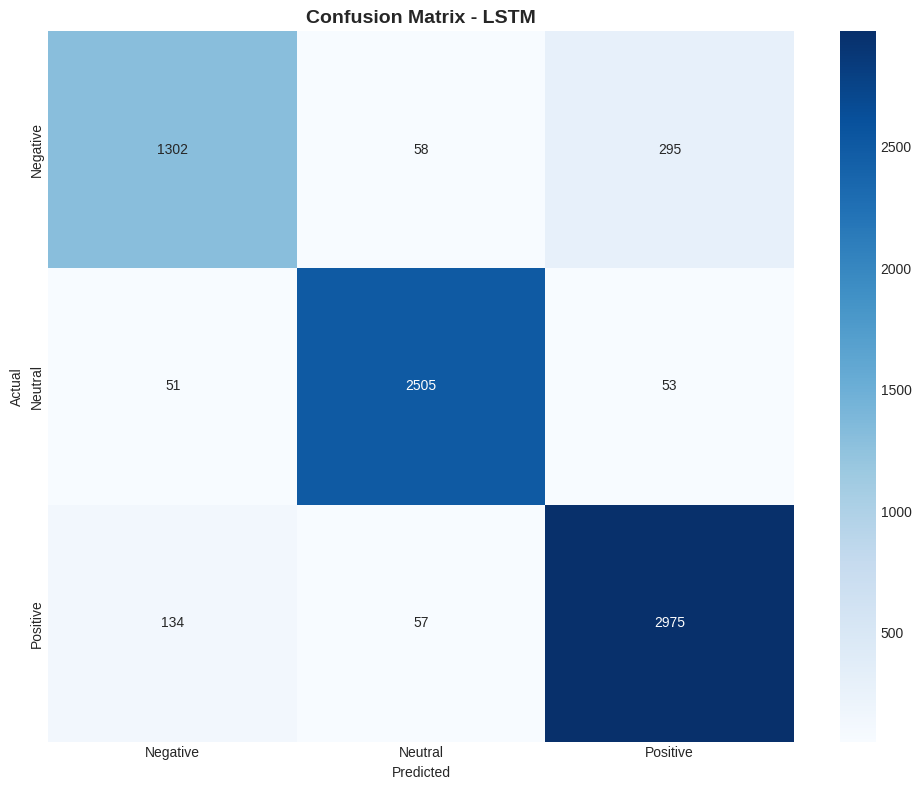

In [ ]:
embedding_dim = 128
vocab_size = len(tokenizer.word_index) + 1
num_classes = len(label_encoder.classes_)

lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

lstm_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print("LSTM Model Architecture:")
lstm_model.summary()

lstm_results = evaluate_model(lstm_model, X_train_padded, y_train, X_test_padded, y_test, "LSTM", is_deep_learning=True)


5. MODEL COMPARISON


In [ ]:
comparison_data = {
    'Model': ['Naive Bayes', 'Logistic Regression', 'Random Forest', 'LSTM (Deep Learning)'],
    'Train Accuracy': [
        nb_results['train_accuracy'],
        lr_results['train_accuracy'],
        rf_results['train_accuracy'],
        lstm_results['train_accuracy']
    ],
    'Test Accuracy': [
        nb_results['test_accuracy'],
        lr_results['test_accuracy'],
        rf_results['test_accuracy'],
        lstm_results['test_accuracy']
    ],
    'Precision': [
        nb_results['precision'],
        lr_results['precision'],
        rf_results['precision'],
        lstm_results['precision']
    ],
    'Recall': [
        nb_results['recall'],
        lr_results['recall'],
        rf_results['recall'],
        lstm_results['recall']
    ],
    'F1-Score': [
        nb_results['f1_score'],
        lr_results['f1_score'],
        rf_results['f1_score'],
        lstm_results['f1_score']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Performance Comparison:")
print(comparison_df.to_string(index=False))


Model Performance Comparison:
               Model  Train Accuracy  Test Accuracy  Precision   Recall  F1-Score
         Naive Bayes        0.715401       0.649394   0.714027 0.649394  0.631575
 Logistic Regression        0.859417       0.815478   0.821087 0.815478  0.809557
       Random Forest        0.699889       0.674563   0.720897 0.674563  0.622003
LSTM (Deep Learning)        0.975100       0.912786   0.912251 0.912786  0.911759


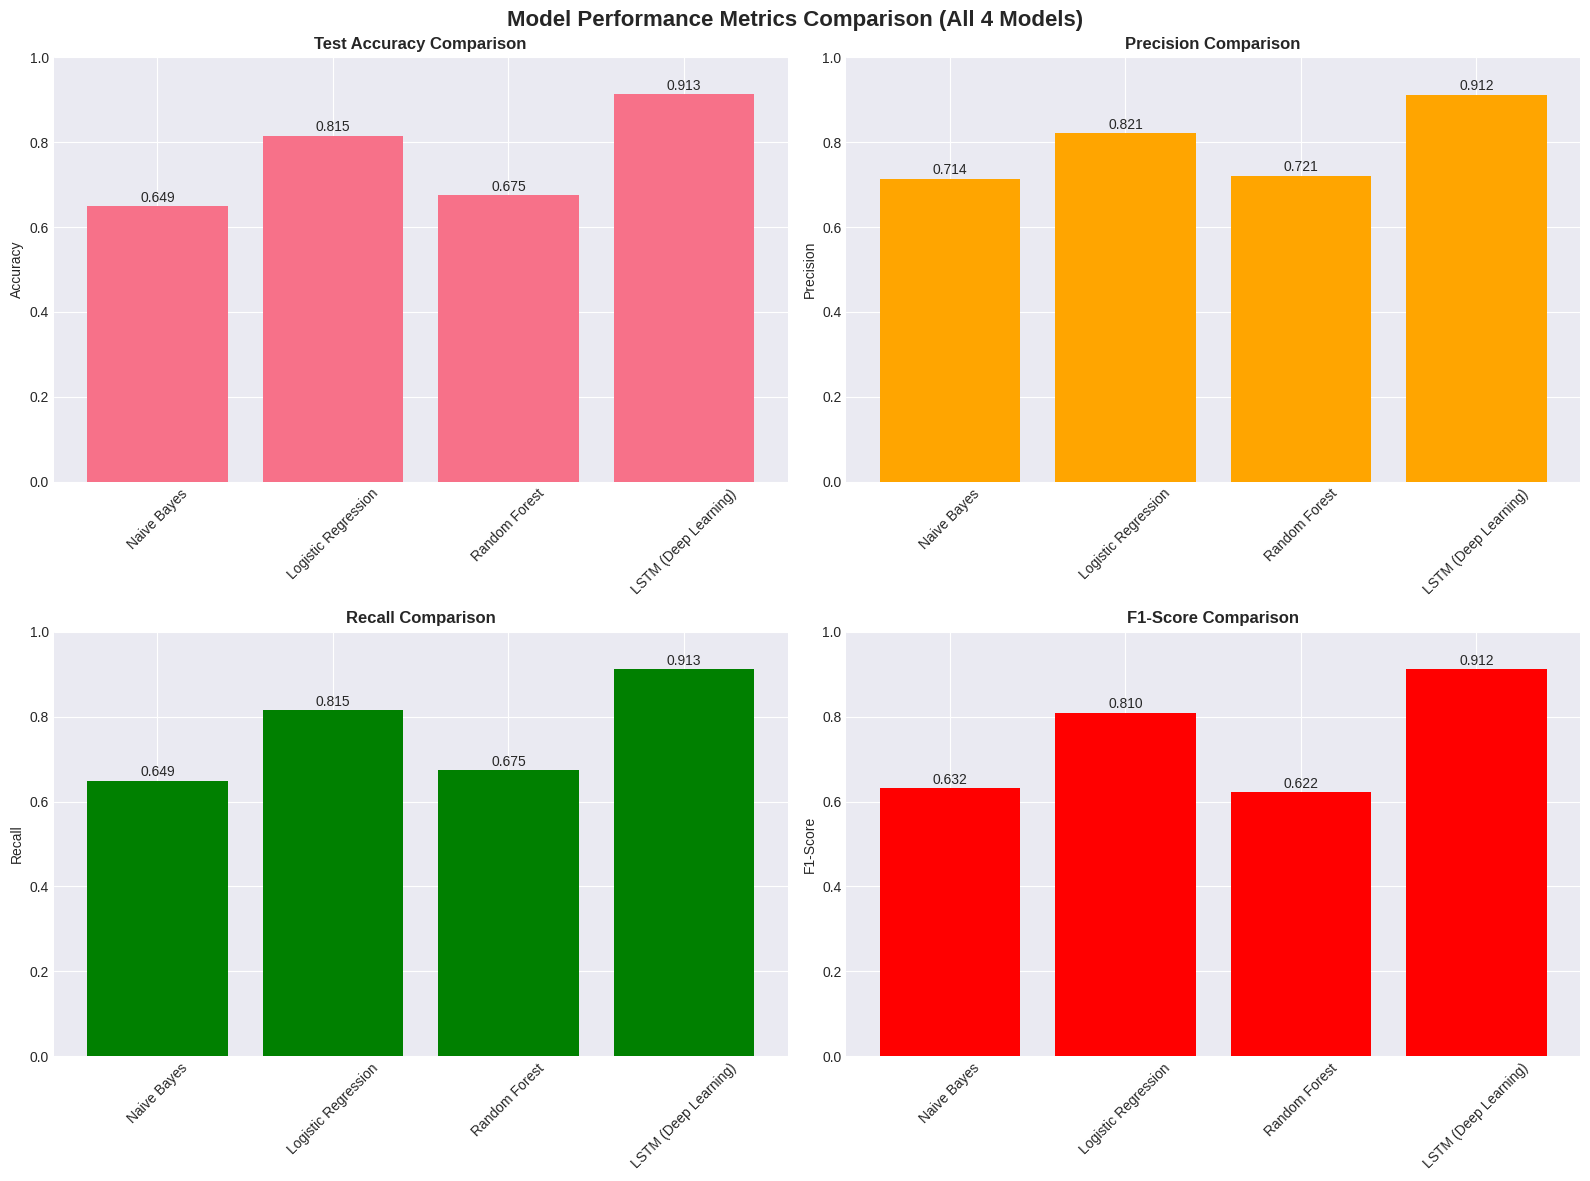

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
# Test Accuracy comparison
axes[0, 0].bar(comparison_df['Model'], comparison_df['Test Accuracy'])
axes[0, 0].set_title('Test Accuracy Comparison', fontweight='bold')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['Test Accuracy']):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center')
# Precision comparison
axes[0, 1].bar(comparison_df['Model'], comparison_df['Precision'], color='orange')
axes[0, 1].set_title('Precision Comparison', fontweight='bold')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_ylim([0, 1])
axes[0, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['Precision']):
    axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center')
# Recall comparison
axes[1, 0].bar(comparison_df['Model'], comparison_df['Recall'], color='green')
axes[1, 0].set_title('Recall Comparison', fontweight='bold')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['Recall']):
    axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center')
# F1-Score comparison
axes[1, 1].bar(comparison_df['Model'], comparison_df['F1-Score'], color='red')
axes[1, 1].set_title('F1-Score Comparison', fontweight='bold')
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].set_ylim([0, 1])
axes[1, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['F1-Score']):
    axes[1, 1].text(i, v + 0.01, f'{v:.3f}', ha='center')
plt.suptitle('Model Performance Metrics Comparison (All 4 Models)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

6. HYPERPARAMETER TUNING FOR BEST TRADITIONAL MODEL

In [ ]:
# Find best traditional model
traditional_models = comparison_df[comparison_df['Model'] != 'LSTM (Deep Learning)']
best_traditional_idx = traditional_models['Test Accuracy'].idxmax()
best_traditional_name = traditional_models.loc[best_traditional_idx, 'Model']


In [ ]:
print(f"Best traditional model: {best_traditional_name}")


Best traditional model: Logistic Regression


In [ ]:
# Tune Logistic Regression
if best_traditional_name == 'Logistic Regression' or True:  # Always tune LR as it's generally good
    print("Performing GridSearch for Logistic Regression...")

    param_grid = {
        'C': [0.1, 1.0, 10.0],
        'solver': ['liblinear', 'lbfgs'],
        'max_iter': [500, 1000]
    }

    lr_grid = GridSearchCV(
        LogisticRegression(random_state=42, multi_class='ovr'),
        param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    lr_grid.fit(X_train_tfidf, y_train)

    print(f"Best parameters: {lr_grid.best_params_}")
    print(f"Best cross-validation score: {lr_grid.best_score_:.4f}")

    y_pred_tuned = lr_grid.predict(X_test_tfidf)
    tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
    print(f"Tuned model test accuracy: {tuned_accuracy:.4f}")


Performing GridSearch for Logistic Regression...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'C': 10.0, 'max_iter': 500, 'solver': 'lbfgs'}
Best cross-validation score: 0.8253
Tuned model test accuracy: 0.8362


7. MODEL SELECTION AND SAVING

In [ ]:
best_model_idx = comparison_df['Test Accuracy'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_accuracy = comparison_df.loc[best_model_idx, 'Test Accuracy']

print(f"Best performing model: {best_model_name}")
print(f"Best test accuracy: {best_accuracy:.4f}")

# Select the best model object
model_mapping = {
    'Naive Bayes': nb_results['model'],
    'Logistic Regression': lr_grid.best_estimator_ if 'lr_grid' in locals() else lr_results['model'],
    'Random Forest': rf_results['model'],
    'LSTM (Deep Learning)': lstm_results['model']
}

best_model = model_mapping[best_model_name]

# Save models
print("Saving models and preprocessors...")

Best performing model: LSTM (Deep Learning)
Best test accuracy: 0.9128
Saving models and preprocessors...


In [ ]:
import joblib

In [ ]:
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [ ]:
joblib.dump(nb_results['model'], 'naive_bayes_model.pkl')
joblib.dump(lr_grid.best_estimator_ if 'lr_grid' in locals() else lr_results['model'], 'logistic_regression_model.pkl')
joblib.dump(rf_results['model'], 'random_forest_model.pkl')


['random_forest_model.pkl']

In [ ]:
lstm_model.save('lstm_model.h5')
joblib.dump(tokenizer, 'tokenizer.pkl')

['tokenizer.pkl']

In [ ]:
def predict_sentiment_traditional(text, model, vectorizer, encoder):
    """Predict sentiment using traditional ML models"""
    processed = preprocess_text(text)
    text_tfidf = vectorizer.transform([processed])
    prediction = model.predict(text_tfidf)[0]
    probability = model.predict_proba(text_tfidf)[0]
    category = encoder.inverse_transform([prediction])[0]

    return {
        'text': text,
        'category': category,
        'confidence': max(probability),
        'probabilities': dict(zip(encoder.classes_, probability))
    }

In [ ]:
def predict_sentiment_deep_learning(text, model, tokenizer, encoder, max_len=100):
    """Predict sentiment using deep learning model"""
    processed = preprocess_text(text)
    sequence = tokenizer.texts_to_sequences([processed])
    padded = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

    prediction_prob = model.predict(padded)[0]
    prediction = np.argmax(prediction_prob)
    category = encoder.inverse_transform([prediction])[0]

    return {
        'text': text,
        'category': category,
        'confidence': max(prediction_prob),
        'probabilities': dict(zip(encoder.classes_, prediction_prob))
    }

9. EXAMPLE PREDICTIONS

In [ ]:
sample_texts = [
    "This product is absolutely amazing! Best purchase ever!",
    "I'm really disappointed with the service.",
    "This is my car",
    "The weather is nice today",
    "I hate waiting in long queues"
]
print("Predictions using best traditional model:")
for text in sample_texts:

    result = predict_sentiment_traditional(text, lr_model, tfidf_vectorizer, label_encoder)
    print(f"\nText: '{text}'")
    print(f"Predicted Category: {result['category']}")
    print(f"Confidence: {result['confidence']:.4f}")

print("\nPredictions using LSTM model:")
for text in sample_texts:
    result = predict_sentiment_deep_learning(text, lstm_model, tokenizer, label_encoder)
    print(f"\nText: '{text}'")
    print(f"Predicted Category: {result['category']}")
    print(f"Confidence: {result['confidence']:.4f}")

Predictions using best traditional model:

Text: 'This product is absolutely amazing! Best purchase ever!'
Predicted Category: Positive
Confidence: 0.9823

Text: 'I'm really disappointed with the service.'
Predicted Category: Negative
Confidence: 0.5665

Text: 'This is my car'
Predicted Category: Neutral
Confidence: 0.6776

Text: 'The weather is nice today'
Predicted Category: Positive
Confidence: 0.8817

Text: 'I hate waiting in long queues'
Predicted Category: Negative
Confidence: 0.9795

Predictions using LSTM model:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

Text: 'This product is absolutely amazing! Best purchase ever!'
Predicted Category: Positive
Confidence: 0.9857
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

Text: 'I'm really disappointed with the service.'
Predicted Category: Negative
Confidence: 0.9677
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

Text: 'This is my car'
Predicted Category: Neutral
Confidence: 0.9888
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

Text: 'The weather is nice today'
Pred

In [ ]:
from google.colab import files

# Download all the saved models
files.download('tfidf_vectorizer.pkl')
files.download('label_encoder.pkl')
files.download('naive_bayes_model.pkl')
files.download('logistic_regression_model.pkl')
files.download('random_forest_model.pkl')
files.download('lstm_model.h5')
files.download('tokenizer.pkl')

print("All models downloaded!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

All models downloaded!
